# The Variability Hypothesis

The [variability hypothesis](https://en.wikipedia.org/wiki/Variability_hypothesis) is the theory that males are generally more variable than females in both physical and psychological traits.
It is a controversial claim, to put it mildly.

As a quick exploration of the topic -- and a demonstration of bootstrap resampling -- let's see whether men are more variable than women in height.
We'll use the 2022 dataset from the Behavioral Risk Factor Surveillance System (BRFSS), which  includes self-reported heights and weights for more than 400,000 respondents.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

<IPython.core.display.Javascript object>

## Data

The following function reads the data in an SAS export format, downloaded from the [BRFSS website](https://www.cdc.gov/brfss/annual_data/annual_2022.html) on August 1, 2024.
It selects the columns we'll use and writes the much smaller excerpt to an HDF file.

In [4]:
def write_hdf():
    """Read the SAS export file and write an HDF file."""
    brfss = pd.read_sas("LLCP2022.XPT.gz")
    columns = ["_SEX", "HTM4", "WTKG3", "_LLCPWT"]
    brfss[columns].to_hdf("LLCP2022.hdf5", key="brfss", complevel=6)

<IPython.core.display.Javascript object>

Rather than download the whole dataset, we can get just the excerpt.

In [5]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/LLCP2022.hdf5")

<IPython.core.display.Javascript object>

Here are the first few rows.

In [6]:
brfss = pd.read_hdf("LLCP2022.hdf5", key="brfss")
brfss.describe()

,_SEX,HTM4,WTKG3,_LLCPWT
count,445132.000000,416480.000000,403054.000000,445132.000000
mean,1.529942,170.269057,8307.447039,594.856344
std,0.499103,10.717750,2144.817270,1134.837415
min,1.000000,91.000000,2268.000000,0.020464
25%,1.000000,163.000000,6804.000000,115.885991
50%,2.000000,170.000000,8074.000000,274.632388
75%,2.000000,178.000000,9525.000000,627.913694
max,2.000000,241.000000,29257.000000,54390.520926


<IPython.core.display.Javascript object>

The dataset includes self-reported heights for almost 200,000 mean and almost 220,000 women.
Here are numbers of males and females with the shortest recorded heights.

In [7]:
xtab = pd.crosstab(brfss["HTM4"], brfss["_SEX"])
xtab.columns = ["Male", "Female"]
xtab.head()

,Male,Female
HTM4,,
91.0,7,17
92.0,0,1
95.0,1,0
97.0,1,3
99.0,1,0


<IPython.core.display.Javascript object>

And the tallest recorded heights.

In [8]:
xtab.tail()

,Male,Female
HTM4,,
226.0,9,2
229.0,4,1
234.0,4,0
236.0,1,0
241.0,4,1


<IPython.core.display.Javascript object>

According to the [codebook](https://www.cdc.gov/brfss/annual_data/2022/pdf/2022-calculated-variables-version4-508.pdf), heights below 91 cm are set to 91 cm, and heights above 241 cm are set to 241 cm.
Even so, some of the remaining values are likely to be errors.
For example, the current tallest woman in the world is 234 cm, so the largest female height in the dataset, 241 cm, was probably reported or recorded incorrectly.

To draw a bootstrap sample from this `DataFrame`, we'll use the following function.

In [9]:
def resample(df):
    """Draw a bootstrap sample.

    df: DataFrame

    returns: DataFrame
    """
    n = len(df)
    return df.sample(n, replace=True, weights="_LLCPWT")

<IPython.core.display.Javascript object>

Here's a single sample we'll use for testing.

In [10]:
sample = resample(brfss)

<IPython.core.display.Javascript object>

## Difference in means

Before we test whether men are more variable than women, let's warm up by confirming that men are taller than women, on average.
We'll use bootstrap resampling to estimate the sampling distribution of the difference in means.
The following is a utility function that computes the difference between the first two elements of a sequence.

In [11]:
def diff(seq):
    """Difference between the first two elements of a sequence.

    seq: sequence

    returns: float
    """
    return np.diff(seq)[0]

<IPython.core.display.Javascript object>

We'll use it to compute the difference in means in a sample, which is the "test statistic".


In [12]:
def diff_means(sample):
    """Difference in average height (M minus F).

    sample: DataFrame with _SEX and HTM4 columns

    returns: float
    """
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    return -diff(grouped_heights.mean())

<IPython.core.display.Javascript object>

The difference is defined so a positive value indicates that men are taller.
Here an example using the bootstrapped sample.

In [13]:
diff_means(sample)

14.455796580284954

<IPython.core.display.Javascript object>

Men are about 14 cm taller than women, on average.

The following function takes a `DataFrame` and a function that computes a test statistic.
It runs resample many times, computes the test statistic for each sample, and returns a list of test statistics.

In [14]:
def sampling_dist(df, test_stat, iters=201):
    """Generate bootstrap samples and compute test statistic.

    df: DataFrame
    test_stat: function that takes a DataFrame
    iters: number of samples

    returns: list of float
    """
    return [test_stat(resample(df)) for i in range(iters)]

<IPython.core.display.Javascript object>

Here's how we call it.
The result is a sample from the sampling distribution of differences in means.

In [15]:
t1 = sampling_dist(brfss, diff_means)
np.mean(t1)

14.433755828000592

<IPython.core.display.Javascript object>

The following function uses KDE to estimate the density of the sampling distribution, uses the estimated density to compute a confidence interval, and generates a plot that shows the sampling distribution, the mean, and the 95% CI.

In [16]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf


def plot_sampling_distribution(data, format_str=".2f", **options):
    """Plot the sampling distribution, mean and CI

    data: sample from the sampling distribution
    format_str: used to format the values
    options: passed to plt.plot
    """
    # compute the mean and CI
    m, s = np.mean(data), np.std(data)
    qs = np.linspace(m - 4 * s, m + 4 * s, 501)
    ps = gaussian_kde(data)(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    low, high = pmf.make_cdf().inverse([0.025, 0.975])

    # plot the density
    pmf.plot(**options)
    inside = pmf[(pmf.qs >= low) & (pmf.qs <= high)]
    plt.fill_between(inside.index, inside, color="gray", alpha=0.2)

    y = pmf.max()
    ax = plt.gca()

    # add text and lines
    plt.text(m, 0.4 * y, "mean", fontsize=14, ha="center")
    plt.text(m, 0.05 * y, f"95% CI", fontsize=14, ha="center")
    plt.plot([m, m], [0, y], ls=":", color="gray")
    plt.plot([low, high], [0, 0], ls="-", color="gray")

    # adjust xticks
    ticks = [low, m, high]
    labels = [format(tick, format_str) for tick in ticks]
    ax.tick_params(axis="x", labelsize=14)
    plt.xticks(ticks, labels)
    plt.yticks([])

    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

<IPython.core.display.Javascript object>

Here are the results for the sampling distribution of the difference in means.

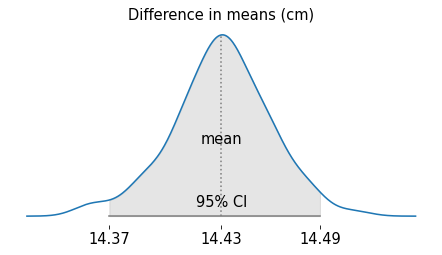

<IPython.core.display.Javascript object>

In [17]:
plot_sampling_distribution(t1)
plt.title("Difference in means (cm)", fontsize=14)
plt.tight_layout()
plt.savefig("variability1.png", dpi=300)

The difference in means is about 14.4 cm.
If we simulate the data collection process and compute the difference in means many times, it varies a little, but it is never close to zero.

The following function estimates the probability that a value from this distribution exceeds 0, which is the p-value for the hypothesis that men are taller than women on average.

In [18]:
from scipy.stats import norm


def p_value(t):
    m, s = np.mean(t), np.std(t)
    if m > 0:
        return norm.cdf(0, m, s)
    else:
        return norm.sf(0, m, s)

<IPython.core.display.Javascript object>

The p-value is so close to zero we can't compute it with floating-point arithmetic, which means it is truly negligible.

In [19]:
p_value(t1)

0.0

<IPython.core.display.Javascript object>

This result means that if we collect another sample this size from the same population, it is practically impossible that the women in the sample would be taller, on average.

To go a step farther, we can reasonably conclude that the difference we see in the sample is very unlikely to have occurred by chance.
Some people who interpret hypothesis tests very formally don't like that conclusion, but [I stand by it](https://allendowney.blogspot.com/2015/05/hypothesis-testing-is-only-mostly.html).

## Difference in standard deviations

OK, now let's get serious.
If men are more variable than women, we expect the standard deviation of their heights to be higher.
To see if it is, all we have to do is provide a function that takes a sample and computes the difference in standard deviations.

In [20]:
def diff_stds(sample):
    """Difference in standard deviation (M minus female)

    sample: DataFrame with `_SEX` and `HTM4` columns

    returns: float
    """
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    return -diff(grouped_heights.std())

<IPython.core.display.Javascript object>

Based on a single resampling, is looks like the standard deviation of heights is higher for men.

In [21]:
diff_stds(sample)

0.7755433526023632

<IPython.core.display.Javascript object>

We can use `sampling_dist` again with a different test statistic.

In [22]:
t2 = sampling_dist(brfss, diff_stds)
np.mean(t2)

0.8125943377103155

<IPython.core.display.Javascript object>

Here's the sampling distribution with its mean and 95% CI.

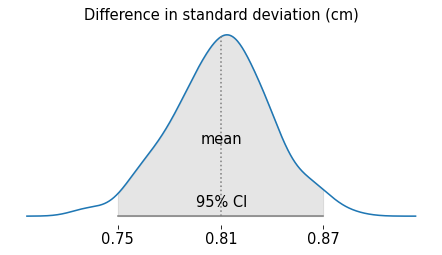

<IPython.core.display.Javascript object>

In [23]:
plot_sampling_distribution(t2)
plt.title("Difference in standard deviation (cm)", fontsize=14)
plt.tight_layout()
plt.savefig("variability2.png", dpi=300)

The 95% CI does not contain zero, which indicates that the difference is significant at the 5% level.
Assuming that the tails of the distribution drop off like the tails of a normal distribution, we can estimate the p-value like this.

In [24]:
p_value(t2)

3.314884452466515e-169

<IPython.core.display.Javascript object>

This p-value is just barely big enough to compute, but still so small we can conclude that the apparent difference is very unlikely to be due to chance.

However, comparing standard deviations might not be a sensible way to assess whether men are more variable.
Men are taller, on average, so if their heights vary more in absolute terms, that's doesn't necessarily means that they vary more in relative terms.
If we think that variation relative to the mean is more relevant to the variability hypothesis, another test statistic to consider is the coefficient of variation.

## Difference in coefficient of variation

The coefficient of variation is the ratio of the standard deviation to the mean, so it quantifies variability in relative terms.
Here's a function that takes a sample and computes the difference in coefficients of variation for men and women.

In [25]:
def diff_cvs(sample):
    """Difference in CV (M minus female)

    sample: DataFrame with `_SEX` and `HTM4` columns

    returns: float
    """
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    means = grouped_heights.mean()
    stds = grouped_heights.std()
    return -diff(stds / means)

<IPython.core.display.Javascript object>

And here's a sample from the sampling distribution of the differences.

In [26]:
t3 = sampling_dist(brfss, diff_cvs)
np.mean(t3)

0.0006739584748971127

<IPython.core.display.Javascript object>

Here's the sampling distribution and a 95% CI.

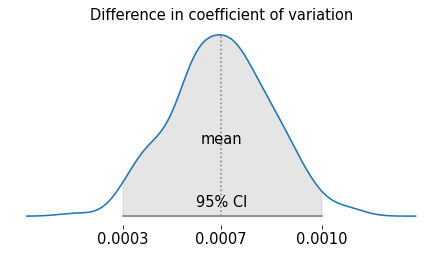

<IPython.core.display.Javascript object>

In [27]:
plot_sampling_distribution(t3, format_str="0.4f")
plt.title("Difference in coefficient of variation", fontsize=14)
plt.tight_layout()
plt.savefig("variability3.png", dpi=300)

The CI does not contain zero, so the difference is statistically significant.
And the p-value is small.

In [28]:
p_value(t3)

4.9123330373066635e-05

<IPython.core.display.Javascript object>

But in practical terms, the difference is very small.
The coefficients of variations are about 0.048.

In [29]:
grouped_heights = sample.groupby("_SEX")["HTM4"]
means = grouped_heights.mean()
stds = grouped_heights.std()
CVs = stds / means
CVs

_SEX
1.0    0.048558
2.0    0.048107
Name: HTM4, dtype: float64

<IPython.core.display.Javascript object>

If we express the difference in CVs and a percentage of the CVs, it is only about 1.4%.

In [30]:
np.mean(t3) / CVs * 100

_SEX
1.0    1.387945
2.0    1.400971
Name: HTM4, dtype: float64

<IPython.core.display.Javascript object>

By this measure of variability, men's heights are slightly more variable than women's, but the difference is so small, it is unlikely to have any practical consequences.

Also, both standard deviation and coefficient of variation are affected by outliers, and we have seen that there are extreme values in this dataset that are probably not correct.
It's possible that the apparent difference in variability, by these test statistics, is the result of data errors.

So let's try again with a more robust statistic.

## Difference in robust CV

As an alternative to the coefficient of variation, we can use a more robust measure of variability.
One option is the ratio of the median absolute deviation (MAD) to the median.
Here's a function that computes it.

In [31]:
def robust_cv(series):
    """Median absolute deviation.

    series: Series of numbers

    returns: float
    """
    m = series.median()
    deviations = series - m
    return deviations.abs().median() / m

<IPython.core.display.Javascript object>

The following function computes the difference in robust CVs.
The first line jitters the data -- otherwise we would get the same results from every resampling.

In [32]:
def diff_robust_cv(sample):
    """Difference in robust CV (M minus female)

    sample: DataFrame with `_SEX` and `HTM4` columns

    returns: float
    """
    sample["HTM4"] += np.random.normal(0, 1, size=len(sample))
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    rcvs = grouped_heights.apply(robust_cv)
    return -diff(rcvs)

<IPython.core.display.Javascript object>

The robust CV of the sample is negative, which suggests that women's heights are more variable.

In [33]:
diff_robust_cv(sample)

-0.0025971928221166715

<IPython.core.display.Javascript object>

Here's the sampling distribution.

In [34]:
t4 = sampling_dist(brfss, diff_robust_cv)
np.mean(t4)

-0.002502441445045549

<IPython.core.display.Javascript object>

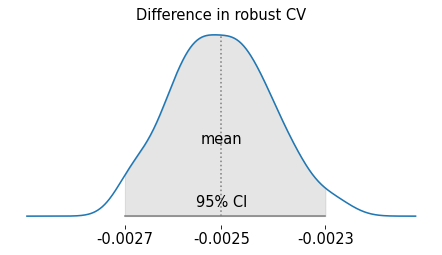

<IPython.core.display.Javascript object>

In [35]:
plot_sampling_distribution(t4, format_str="0.4f")
plt.title("Difference in robust CV", fontsize=14)
plt.tight_layout()
plt.savefig("variability4.png", dpi=300)

And the p-value.

In [36]:
p_value(t4)

6.93074075784399e-122

<IPython.core.display.Javascript object>

According to the robust CV, women are more variable, but again the difference is so small it has no practical consequences.

## Discussion

This example demonstrates a strength of bootstrap resampling -- it is easy to explore multiple test statistics and consider which is most relevant to the hypothesis in question.

* If we compare standard deviations of height, men are more variable, but that's not too surprising -- men are taller, and almost any process that makes bigger things probably makes more variable things, too.

* Coefficient of variation might be a better way to compare things with different sizes. By that standard, men are still slightly more variable, but the difference is so small, it's hard to imagine it has any practical consequences.

* And it might be an artifact of errors in the data. If we use a robust alternative to the coefficient of variation -- MAD divided by median -- women are more variable. But again, it is probably not a difference that makes a difference.

In conclusion, the distribution of human height doesn't provide much support for the variability hypothesis.

## Difference in IQR / median

Here's one more robust measure of variability.

In [37]:
def diff_relative_iqr(sample):
    """Difference in IQR / median (M minus female)

    sample: DataFrame with `_SEX` and `HTM4` columns

    returns: float
    """
    sample["HTM4"] += np.random.normal(0, 1, size=len(sample))
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    medians = grouped_heights.median()
    
    # the results depend on which quantiles we use
    iqrs = grouped_heights.quantile(0.75) - grouped_heights.quantile(0.25)
    #iqrs = grouped_heights.quantile(0.95) - grouped_heights.quantile(0.05)
    
    return -diff(iqrs / medians)

<IPython.core.display.Javascript object>

In [38]:
diff_relative_iqr(sample)

0.005576081276326472

<IPython.core.display.Javascript object>

In [39]:
t5 = sampling_dist(brfss, diff_relative_iqr)
np.mean(t5)

0.006708941428486647

<IPython.core.display.Javascript object>

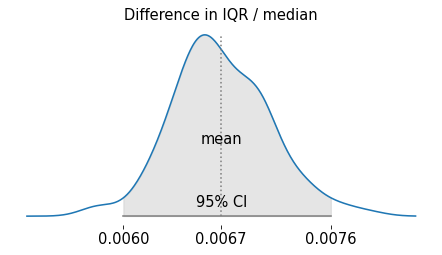

<IPython.core.display.Javascript object>

In [40]:
plot_sampling_distribution(t5, format_str="0.4f")
plt.title("Difference in IQR / median", fontsize=14)
plt.tight_layout()
plt.savefig("variability5.png", dpi=300)

In [41]:
p_value(t5)

5.484332495278092e-72

<IPython.core.display.Javascript object>